In [1]:
from datascience import *
import numpy as np
from math import *
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

## Hypothesis Testing

In Data8.2x, you have been using simulation to conduct hypothesis testing. Now that we have completed Data8.2x, this is a good time to take a step back and reflect on hypothesis testing. 

Every hypothesis test has roughly the same structure. The following 4 steps provide a rough outline:

1) State the null and alternate hypotheses. Generally, the alternate hypothesis is what you are trying to show. Essentially, if you want to show a result, we assume the opposite is true and try to prove ourselves wrong. 

2) Determine/calculate a test statistic. See your book for a formal definition, but generally, the test statistic is any quantity that helps us evaluate our sample with respect to our null hypothesis. 

3) Determine distribution of test statistic and compute a $p$-value. If you have taken inferential statistics before, you likely computed a $z$ or $t$ statistic and used a calculator or table to compute a $p$-value. This is based on asymptotic theory of sample means/proportions. This is not the approach taken in Data8.2x. With better computing power, we can use simulation to obtain an empirical distribution of our test statistic under the null hypothesis. 

4) Conclude. For low $p$-value (generally below 0.05), we reject the null hypothesis. For high $p$-value, we fail to reject. Low $p$-value implies that our sample would be very unusual if the null hypothesis were actually true. Therefore, that is evidence that the null hypothesis is wrong. 

### Example

Let's work through an example. Suppose that in the upcoming election, Referendum A is up for approval in Colorado. You suspect that in El Paso County, more than half of eligible voters support the referendum. You collect a random sample of 200 eligible voters in El Paso County and 115 of them express support. Is there evidence to conclude that supports your suspicion? 

#### Step 1: Hypothesis

State the null and alternative hypotheses.

$$H_{0}: \pi = .5$$
$$H_{a}: \pi > .5$$

#### Step 2: Test Statistic

Select a test statistic and compute that test statistic for the sample.

The test statistic is a random variable and is  
$X$ = The number of voters in support out of 200 that exceed 100.

For our data, the observed value of $X$ is $x$ = 115 - 100 =15

#### Step 3: $p$-value

3a) If $H_0$ were true, what should the value of the test statistic be close to? In other words, if in fact, half of eligible voters support the referendum, what value should your test statistic take? 

It should be close to zero.

3b) In words (and in the context of this problem), describe what the $p$-value is. 

If the true proportion of voters in favor of the referendum was 0.5, then the p-value is the probability of getting 15 more voters in excess of 100.

3c) Find the $p$-value directly and using simulation. Hint: the binomial distribution will be of use here. 

### Using a known distribution
First, we know from our prior work that the distribution of our test statistic is a binomial. It is shifted which scipy can handle with the location parameter.

In [2]:
# Our statistic is a binomial
from scipy import stats
my_binom = stats.binom(n=200,p=0.5,loc=-100)

Our p-value is:

In [3]:
1-my_binom.cdf(14)

0.020018595806698514

Checking our work.

In [4]:
1-stats.binom.cdf(114,200,0.5)

0.020018595806698514

In [5]:
stats.binom_test(x=115,n=200,p=0.5,alternative="greater")

0.020018595806698482

Using the central limit theorem, $X$ would be normal with mean 0 and variance $npq$ which is 50.  

If we let $Y$ be the number of voters in favor of the referendum out of 200. It is a binomial. For this $X = Y -100$.  $E(X) = E(Y-100)=E(Y)-100=200*p -100$.  Under the null hypothesis $p=0.50$ so $E(X) = 0 $.  For the variance, we have $V(X)=V(Y-100)=V(Y)=npq=200(.5)(.5)=50$.

In [6]:
1-stats.norm.cdf(15,0,np.sqrt(50))

0.01694742676234462

This is close to our exact value. The central limit theorem applies when we are adding variables together. This is happening if we think about adding the 200 voters as 0 and 1s.

### Using simulation 
To simulate, we will simulate the test statistic value under the null model. Under the null, $X$ is a shifted binomial.

In [7]:
sim_num=10000
test_stat=15
np.count_nonzero(my_binom.rvs(sim_num)>=test_stat)/sim_num

0.0198

#### Step 4: Conclude

What is your conclusion? Be sure to state your conclusion in the context of the problem.

It is statistically significant but only marginally. I would collect more data.

## Confidence Intervals

Construct and interpret a 95% confidence interval on your test statistic. There maybe be many ways to construct such an interval (bootstrap, the binomial distribution, asymptotically). Select one and implement. 

Also, compare your interval to the results of your hypothesis test. Does your interval contain the value 0.5? Why does that matter? 

### Bootstrap 

We will write the data as 85 zeros and 115 ones. We then sample with replacement from this sample and calculated the test statistic. This is the sum of the ones minus one hundred. We will repeat this a large number of times to get the distribution of the test statistic. The lower 95% confidence bound will be the 5th percentile of this distribution.

In [8]:
my_data=np.repeat([0,1],[85,115])

In [9]:
np.random.seed(951)
my_boot=[]
for _ in np.arange(10000):
    my_boot = np.append(my_boot,sum(np.random.choice(my_data,size=200))-100)

In [10]:
test_stat=Table().with_column("Test Statistic",my_boot)
test_stat

Test Statistic
21
19
9
9
17
17
23
10
8
7


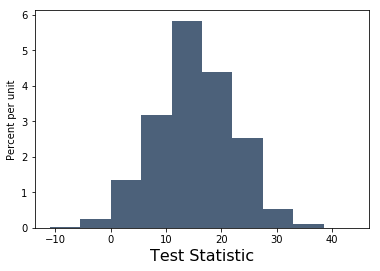

In [11]:
test_stat.hist()

In [12]:
test_stat.percentile(5)

Test Statistic
3


We are 95% confident that the true proportion of voters in favor of the referendum is greater than $\frac{103}{200} = 0.515$.

In [13]:
103/200

0.515

### Inverting hypothesis test  

We need to find the value of the probability of success such that we reject the hypothesis test. For this we need to use a root finder to find the probability such that the cummulative area is 0.05. We will write a scipy function for this.

In [14]:
def ci(p):
    return 1-stats.binom.cdf(114,200,p)

In [15]:
from scipy import optimize

In [16]:
optimize.root(lambda x:(ci(x) - .05), [.6],method='hybr').x

array([0.51445244])

Our 95% lower confidence bound is 0.514. That is we are 95% confident that the true proportion of voters in support of the referendum is at least 0.514. This is greater than 0.5 which agrees with our hypothesis test.

In [17]:
# Check our number
ci(.51445)

0.049992884132578186

## Alternative Test Statistic 

Many people start with an estimate of the population parameter. In this case it would be $P = \frac{Y}{n}$ where $Y$ is the number of voters out of 200 in support of the referendum. This is an estimate of the population proportion. A test statistic would be *how close is this to the hypothesized value of 0.5?*. Close is further clarrified by dividing by the standard deviation of $P$, which is called the standard error. We have $E(P) = p$ and $V(P) = \frac{p(1-p)}{n}$. The typical test statistic used in AP stats, Math 356, etc. is  
$$z = \frac{p-.5}{\sqrt{\frac{p(1-p)}{n}}}$$

The distribution of this test statistic is approximately normal in the number of successes and failures are greater than or equal to 5. This heuristic comes from making sure we are not too close to 0 or 1. Close here means at least 3 standard deviations before the distribution crosses 0 or 1.